## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 16 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.9]
redice_lr_patient = [5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(
        factor=reduce_factor, 
        min_lr=1e-12, 
        monitor='val_loss', 
        patience=reduce_patient, 
        verbose=1
    )
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

Train on 50000 samples, validate on 10000 samples
Epoch 1/16
50000/50000 [==============================] - 5s 95us/step - loss: 2.2442 - accuracy: 0.2644 - val_loss: 2.1495 - val_accuracy: 0.2046
Epoch 2/16
50000/50000 [==============================] - 4s 84us/step - loss: 1.7756 - accuracy: 0.3850 - val_loss: 1.9675 - val_accuracy: 0.2964
Epoch 3/16
50000/50000 [==============================] - 4s 83us/step - loss: 1.6429 - accuracy: 0.4254 - val_loss: 1.8363 - val_accuracy: 0.3531
Epoch 4/16
50000/50000 [==============================] - 4s 84us/step - loss: 1.5687 - accuracy: 0.4513 - val_loss: 1.7236 - val_accuracy: 0.3928
Epoch 5/16
50000/50000 [==============================] - 4s 83us/step - loss: 1.5117 - accuracy: 0.4699 - val_loss: 1.6549 - val_accuracy: 0.4152
Epoch 6/16
50000/50000 [==============================] - 4s 84us/step - loss: 1.4651 - accuracy: 0.4892 - val_loss: 1.5972 - val_accuracy: 0.4348
Epoch 7/16
50000/50000 [==============================] - 4s 84us/st

50000/50000 [==============================] - 4s 87us/step - loss: 1.3746 - accuracy: 0.5151 - val_loss: 1.6953 - val_accuracy: 0.4006
Epoch 4/16
50000/50000 [==============================] - 4s 87us/step - loss: 1.2972 - accuracy: 0.5418 - val_loss: 1.8390 - val_accuracy: 0.3480
Epoch 5/16
50000/50000 [==============================] - 4s 87us/step - loss: 1.2349 - accuracy: 0.5644 - val_loss: 1.5918 - val_accuracy: 0.4414
Epoch 6/16
50000/50000 [==============================] - 4s 87us/step - loss: 1.1729 - accuracy: 0.5897 - val_loss: 1.9579 - val_accuracy: 0.3403
Epoch 7/16
50000/50000 [==============================] - 4s 90us/step - loss: 1.1172 - accuracy: 0.6072 - val_loss: 2.0307 - val_accuracy: 0.3460
Epoch 8/16
50000/50000 [==============================] - 5s 91us/step - loss: 1.0674 - accuracy: 0.6228 - val_loss: 1.7800 - val_accuracy: 0.4112
Epoch 9/16
50000/50000 [==============================] - 4s 87us/step - loss: 1.0245 - accuracy: 0.6392 - val_loss: 1.9208 - val

Epoch 5/16
50000/50000 [==============================] - 5s 92us/step - loss: 1.2437 - accuracy: 0.5620 - val_loss: 1.5087 - val_accuracy: 0.4610
Epoch 6/16
50000/50000 [==============================] - 5s 92us/step - loss: 1.1939 - accuracy: 0.5815 - val_loss: 1.4660 - val_accuracy: 0.4793
Epoch 7/16
50000/50000 [==============================] - 5s 92us/step - loss: 1.1449 - accuracy: 0.5994 - val_loss: 1.4458 - val_accuracy: 0.4836
Epoch 8/16
50000/50000 [==============================] - 5s 92us/step - loss: 1.0979 - accuracy: 0.6164 - val_loss: 1.4281 - val_accuracy: 0.4912
Epoch 9/16
50000/50000 [==============================] - 5s 92us/step - loss: 1.0593 - accuracy: 0.6327 - val_loss: 1.4593 - val_accuracy: 0.4827
Epoch 10/16
50000/50000 [==============================] - 5s 92us/step - loss: 1.0233 - accuracy: 0.6422 - val_loss: 1.4068 - val_accuracy: 0.5010
Epoch 11/16
50000/50000 [==============================] - 5s 92us/step - loss: 0.9888 - accuracy: 0.6574 - val_loss:

50000/50000 [==============================] - 6s 111us/step - loss: 1.1718 - accuracy: 0.5863 - val_loss: 2.0328 - val_accuracy: 0.3228
Epoch 8/16
50000/50000 [==============================] - 6s 113us/step - loss: 1.1275 - accuracy: 0.6039 - val_loss: 1.7169 - val_accuracy: 0.4207
Epoch 9/16
50000/50000 [==============================] - 6s 116us/step - loss: 1.0873 - accuracy: 0.6189 - val_loss: 1.7181 - val_accuracy: 0.4078
Epoch 10/16
50000/50000 [==============================] - 6s 113us/step - loss: 1.0447 - accuracy: 0.6356 - val_loss: 1.7944 - val_accuracy: 0.3995
Epoch 11/16
50000/50000 [==============================] - 6s 117us/step - loss: 1.0046 - accuracy: 0.6486 - val_loss: 1.5933 - val_accuracy: 0.4461
Epoch 12/16
50000/50000 [==============================] - 6s 115us/step - loss: 0.9727 - accuracy: 0.6592 - val_loss: 1.5781 - val_accuracy: 0.4581
Epoch 13/16
50000/50000 [==============================] - 6s 113us/step - loss: 0.9326 - accuracy: 0.6737 - val_loss: 1

Epoch 10/16
50000/50000 [==============================] - 8s 158us/step - loss: 1.0445 - accuracy: 0.6326 - val_loss: 1.9086 - val_accuracy: 0.3768
Epoch 11/16
50000/50000 [==============================] - 8s 158us/step - loss: 1.0031 - accuracy: 0.6480 - val_loss: 1.5852 - val_accuracy: 0.4521
Epoch 12/16
50000/50000 [==============================] - 8s 158us/step - loss: 0.9721 - accuracy: 0.6567 - val_loss: 1.8999 - val_accuracy: 0.3899
Epoch 13/16
50000/50000 [==============================] - 8s 158us/step - loss: 0.9385 - accuracy: 0.6714 - val_loss: 1.7395 - val_accuracy: 0.4373
Epoch 14/16
50000/50000 [==============================] - 8s 158us/step - loss: 0.9054 - accuracy: 0.6810 - val_loss: 1.6357 - val_accuracy: 0.4458
Epoch 15/16
50000/50000 [==============================] - 8s 158us/step - loss: 0.8647 - accuracy: 0.6967 - val_loss: 1.8001 - val_accuracy: 0.4255
Epoch 16/16
50000/50000 [==============================] - 8s 158us/step - loss: 0.8344 - accuracy: 0.7102

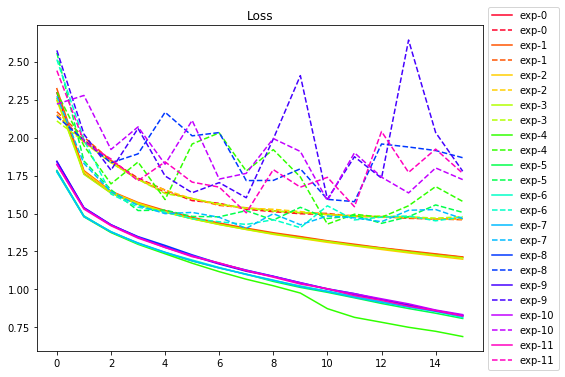

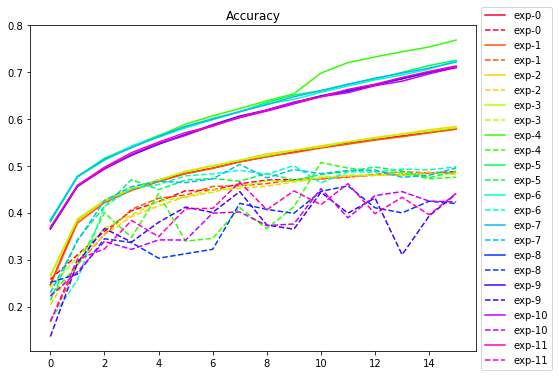

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()